In [1]:
import io
import torch
import torchaudio
import torchvision
import numpy as np
from datasets import load_dataset
from IPython.display import display, Audio, Image, update_display, HTML
from torchvision.transforms import ToPILImage
from fastprogress.fastprogress import master_bar, progress_bar
from audio_mvrt import MaxViT1D

/home/dgj335/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
device = "cuda:2"
class Config: pass
config = Config()
config.batch_size = 64
config.num_workers = 24
config.grad_accum_steps = 1
config.plot_update = 64
config.patience = 64
config.min_lr = 1e-7
config.max_lr = 1e-5
config.warmup_steps = 5000
config.weight_decay = 0.
config.epochs = 30
config.epoch_len = 10000

config.length_samples = 2**18
config.patch_size = config.length_samples//256
config.channels = 2
config.embed_dim = 192
config.num_classes = config.channels*config.patch_size
config.depth = (4,)
config.downsample = False
config.heads = 3
config.mlp_dim = 768
config.dim_head = 64
config.dim_conv_stem = 192
config.window_size = 16
config.mbconv_expansion_rate = 4
config.mbconv_shrinkage_rate = 0.25
config.dropout = 0.0
config.num_register_tokens = 4
config.dense_prediction = True

In [3]:
model = MaxViT1D(
    channels = config.channels,
    patch_size = config.patch_size,
    num_classes = config.num_classes,
    dim = config.embed_dim,
    depth = config.depth,
    downsample = config.downsample,
    # heads = config.heads, # calculated as dim//dim_head  
    # mlp_dim = config.mlp_dim, # calculated as 4*dim
    dim_head = config.dim_head,
    dim_conv_stem = config.dim_conv_stem,
    window_size = config.window_size,
    mbconv_expansion_rate = config.mbconv_expansion_rate,
    mbconv_shrinkage_rate = config.mbconv_shrinkage_rate,
    dropout = config.dropout,
    num_register_tokens = config.num_register_tokens,
    dense_prediction=True
).to(device)

sum(p.numel() for p in model.parameters())/1e6

6.734912

In [4]:
train_dataset = load_dataset("danjacobellis/musdb18hq_vss",split='train')
valid_dataset = load_dataset("danjacobellis/musdb18hq_vss",split='validation')

In [5]:
L = config.length_samples
C = config.channels
crop = torchvision.transforms.RandomCrop((2,L))
valid_crop = torchvision.transforms.CenterCrop((2,L))
def collate_fn(batch):
    B = len(batch)
    x = torch.zeros( (B, C, 2, L), dtype=torch.float32)
    i_sample = 0
    for i_sample, sample in enumerate(batch):
        audio_mix, fs = torchaudio.load(sample['audio_mix']['bytes'])
        audio_vocal, fs = torchaudio.load(sample['audio_vocal']['bytes'])
        audio_mix = audio_mix.unsqueeze(1)
        audio_vocal = audio_vocal.unsqueeze(1)
        audio = torch.cat([audio_mix,audio_vocal],dim=1)
        x[i_sample,:,:,:] = crop(audio)
    return x[:,:,0,:], x[:,:,1]

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros( (B, C, 2, L), dtype=torch.float32)
    i_sample = 0
    for i_sample, sample in enumerate(batch):
        audio_mix, fs = torchaudio.load(sample['audio_mix']['bytes'])
        audio_vocal, fs = torchaudio.load(sample['audio_vocal']['bytes'])
        audio_mix = audio_mix.unsqueeze(1)
        audio_vocal = audio_vocal.unsqueeze(1)
        audio = torch.cat([audio_mix,audio_vocal],dim=1)
        x[i_sample,:,:,:] = valid_crop(audio)
    return x[:,:,0,:], x[:,:,1,:]

In [6]:
valid_batch = valid_dataset[200:201]
valid_batch = [dict(zip(valid_batch.keys(), values)) for values in zip(*valid_batch.values())]
x_valid, v_valid = valid_collate_fn(valid_batch)
x_valid = x_valid.to(device)
v_valid = v_valid.to(device)

In [7]:
def make_spectrogram(X):
    X = spectrogram(X).log()
    X = X - X.mean()
    X = X/X.std()
    X = X/3
    X = X.clamp(-0.5,0.5)
    X = X + 0.5
    return ToPILImage()(X)

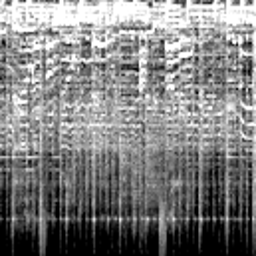

In [8]:
spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,
    n_fft=4096,
).to(device)
SG = make_spectrogram(x_valid[0,0].to(device))
SG.resize((256,256))

In [9]:
Audio(x_valid.to("cpu").numpy()[0],rate=44100)

In [10]:
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    weight_decay=0.0,
    lr = config.min_lr
)

def minus_cosine_warmup(i_step):
    scale = 0.5 * (np.log10(config.max_lr) - np.log10(config.min_lr))
    angle =  np.pi * i_step / (config.warmup_steps//config.plot_update)
    log_lr = np.log10(config.min_lr) + scale * (1 - np.cos(angle))
    lr = 10 ** log_lr
    return lr/config.min_lr
    
warmup = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: minus_cosine_warmup(i_step)
)

reduce_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.98,
    patience=config.patience,
    threshold=1e-5,
    min_lr=config.min_lr
)

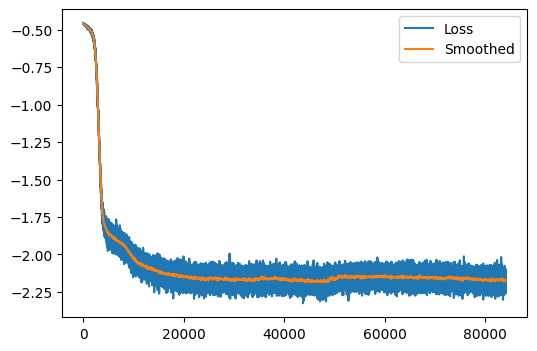

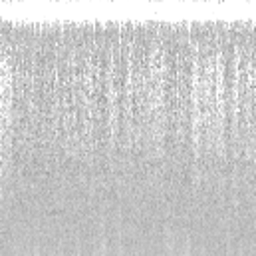

In [ ]:
losses = []
learning_rates = [optimizer.param_groups[0]['lr']]
img_displays = []
text_display = None
model.train()
optimizer.zero_grad()
mb = master_bar(range(config.epochs))
mb.names = ['Loss', 'Smoothed']
i_step = 0
for i_epoch in mb:
    sampler = torch.utils.data.RandomSampler(
        train_dataset,
        replacement=True,
        num_samples=config.epoch_len*config.batch_size
    )
    dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        sampler=sampler,
        drop_last=True,
        collate_fn=collate_fn
    )
   
    for i, (x,v) in enumerate(progress_bar(dataloader, parent=mb)):
        x = x.to(device)
        v = v.to(device)

        pred = model(x)
        mse_loss = torch.nn.functional.mse_loss(pred, x-v)
        losses.append(np.log10(mse_loss.item()))
        mse_loss.backward()
        if (i + 1) % config.grad_accum_steps == 0: 
            optimizer.step()
            optimizer.zero_grad()
        
        # plotting and lr scheduler
        if len(losses) % config.plot_update == 0:
            plot_n = len(losses) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(losses).reshape(plot_n, -1).mean(dim=1)
            dist_x = range(len(losses))
            dist_y = losses
            mb.update_graph([[dist_x, dist_y],[smoothed_x, smoothed_y]])
            mb.child.comment = f'loss {smoothed_y[-1]:.4g}; lr {learning_rates[-1]:.4g}'

            # lr scheduler
            if i_step < config.warmup_steps:
                warmup.step()
            else:
                reduce_plateau.step(smoothed_y[-1])
            learning_rates.append(optimizer.param_groups[0]['lr'])

            with torch.no_grad():
                model.eval()
                y_valid = model(x_valid)[0]
                torchaudio.save(f"valid_{device}.wav", src=y_valid.to("cpu"), sample_rate=44100)
                buffer = io.BytesIO()
                make_spectrogram(y_valid).resize((256,256)).save(buffer, format="PNG")
                model.train()
            buffer.seek(0)
            if len(img_displays) == 0:
                img_displays.append(display(Image(buffer.read()), display_id=True))
            else:
                update_display(Image(buffer.read()), display_id=img_displays[0].display_id)
        i_step+=1
        
        torch.save({
            'model_state_dict': model.state_dict(),
            'i_epoch': i_epoch,
            'learning_rates': learning_rates,
            'train_loss': losses,
            'config': config
        }, f"log_{device}.pth")

In [12]:
from IPython.display import display, Image, update_display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

In [13]:
with torch.no_grad():
    model.eval()
    y_valid = model(x_valid)[0]
    torchaudio.save(f"valid_{device}.wav", src=y_valid.to("cpu"), sample_rate=44100)
    buffer = io.BytesIO()
    make_spectrogram(y_valid).resize((256,256)).save(buffer, format="PNG")

In [15]:
Audio(y_valid.cpu()[0],rate=44100)

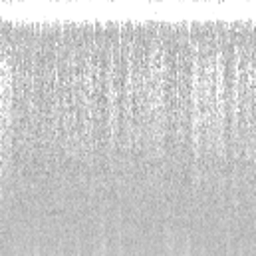

In [16]:
buffer.seek(0)
display(Image(buffer.read()))